# CS7180 Final Project - Prototypical Networks experimentation

The code in the first half of this notebook is taken directly from the [few shot learning tutorial notebook](https://github.com/sicara/easy-few-shot-learning/blob/master/notebooks/my_first_few_shot_classifier.ipynb) from the [easy-few-shot-learning Github repo](https://github.com/sicara/easy-few-shot-learning) by Sicara.

The tutorial creates a Prototypical Networks model and uses custom dataloader functions from the easyfsl library to create training and test sets from the Omniglot dataset. Then it measures prediction accuracy of the model when it is given 5 support samples (5-shot) per class.

In [ ]:
#install easyfsl library
!pip install easyfsl

In [46]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torchvision.datasets import STL10
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

## Create PrototypicalNetworks class. 

The forward function uses Euclidean distance (cdist) as a measure to determine the distance between the features of a query image and the class prototype. The pre-trained convolutional backbone is resnet18.

In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

## Create train and test sets from Omniglot.

In [47]:
image_size = 28


train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified


## Create the DataLoader. 
Set the number of ways, shots, query images, and evaulation tasks. Then use EasyFSL's custom TaskSampler function to create a DataLoader that will sample images evenly among classes according to specified number of shots and ways. Without this sampler function, the built-in pytorch Dataloader will create random batches that are not in the necessary form for a few-shot learning task.

In [48]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

## Visualize support images and query images. 

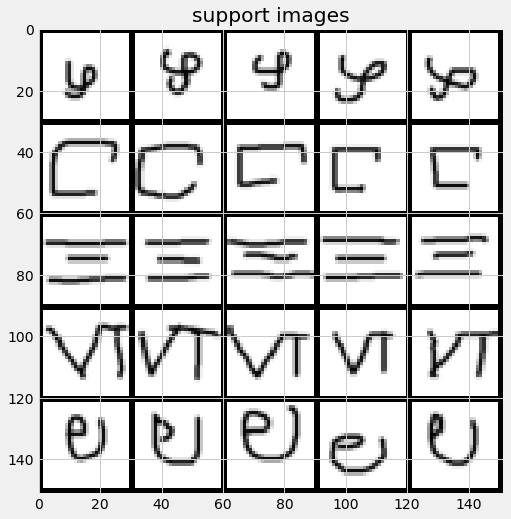

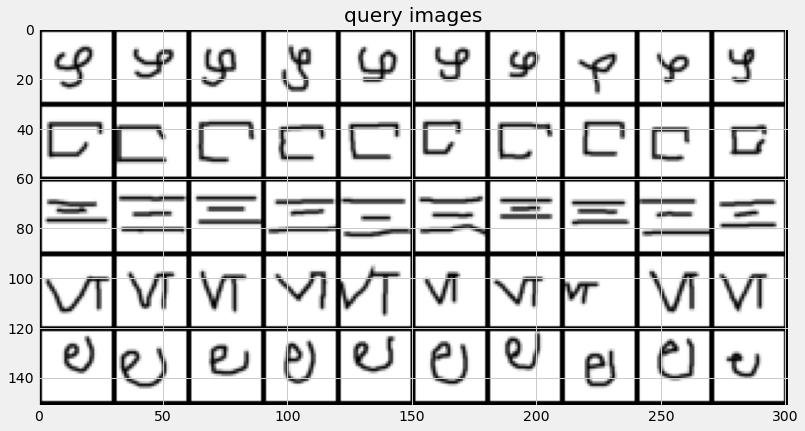

In [49]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

## Evaluate the model 

Running predictions on 100 randomly generated tasks based on the support set of 5 images per class returns accuracy of 85.94%. Predictions are based on the Euclidean distance between the class prototypes and the query image; the pre-trained Resnet18 model is not trained on the Omniglot images.

In [50]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct
            accuracy = 100 * correct_predictions/total_predictions

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {accuracy:.2f}%"
    )
    return accuracy


evaluate(test_loader)

100%|██████████| 100/100 [00:05<00:00, 17.98it/s]

Model tested on 100 tasks. Accuracy: 85.94%


85.94

# Original contributions

Using the same code from the easy-few-shot-learning repo, I create a script that iterates over a range of "n-shots" between 1 and 10 in order to test how accuracy changes based on the number of support images per class.  

In [51]:

results = [] #create an empty list to store accuracy scores in.

N_WAY = 5  # Number of classes in a task
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 200

def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
  ) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)

for i in range(1,11):
  test_set.get_labels = lambda: [
      instance[1] for instance in test_set._flat_character_images
  ]
  test_sampler = TaskSampler(
      test_set, n_way=N_WAY, n_shot=i, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
  )

  test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
  )

    # We'll count everything and compute the ratio at the end
  total_predictions = 0
  correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
  model.eval()
  with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(test_loader), total=len(test_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct
            accuracy = 100 * correct_predictions/total_predictions

  results.append(accuracy)
  print(
        f"Model tested on {len(test_loader)} tasks. Nshot = {i} Accuracy: {accuracy:.2f}%"
    )


100%|██████████| 200/200 [00:07<00:00, 25.57it/s]

Model tested on 200 tasks. Nshot = 1 Accuracy: 72.32%



100%|██████████| 200/200 [00:08<00:00, 24.90it/s]

Model tested on 200 tasks. Nshot = 2 Accuracy: 80.30%



100%|██████████| 200/200 [00:08<00:00, 23.70it/s]

Model tested on 200 tasks. Nshot = 3 Accuracy: 83.35%



100%|██████████| 200/200 [00:09<00:00, 21.59it/s]

Model tested on 200 tasks. Nshot = 4 Accuracy: 85.44%



100%|██████████| 200/200 [00:09<00:00, 20.59it/s]

Model tested on 200 tasks. Nshot = 5 Accuracy: 86.49%



100%|██████████| 200/200 [00:10<00:00, 18.46it/s]

Model tested on 200 tasks. Nshot = 6 Accuracy: 87.08%



100%|██████████| 200/200 [00:11<00:00, 17.28it/s]

Model tested on 200 tasks. Nshot = 7 Accuracy: 87.67%



100%|██████████| 200/200 [00:12<00:00, 16.65it/s]

Model tested on 200 tasks. Nshot = 8 Accuracy: 87.55%



100%|██████████| 200/200 [00:12<00:00, 16.43it/s]

Model tested on 200 tasks. Nshot = 9 Accuracy: 88.06%



100%|██████████| 200/200 [00:12<00:00, 16.00it/s]

Model tested on 200 tasks. Nshot = 10 Accuracy: 88.74%


Even with only 1 shot, the model is able to accurately predict the class of a query image 72% of the time. With 10 shots, accuracy is 88.74%

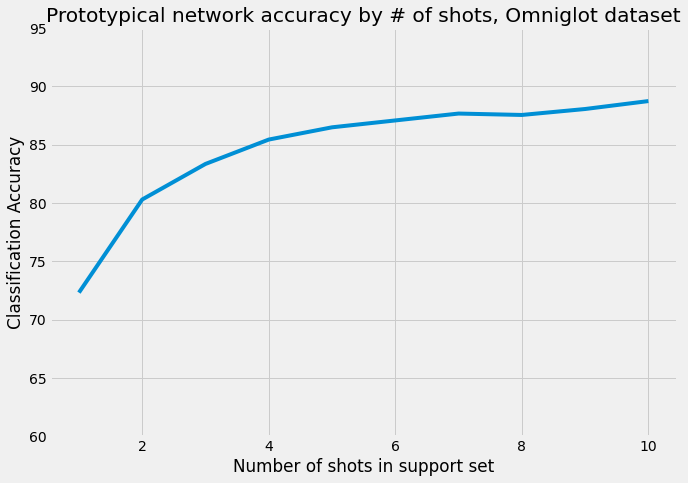

In [52]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
x = range(1,11)

plt.rcParams['figure.figsize'] = [10, 7]
plt.plot(x,results)
plt.ylim([60, 95])
plt.xlabel("Number of shots in support set")
plt.ylabel("Classification Accuracy")
plt.title("Prototypical network accuracy by # of shots, Omniglot dataset")
plt.savefig("omniglot.jpg")

## Creating a function to test the effect of the number of shots on accuracy for any image dataset

The following function takes in an image dataset and tests prediction accuracy when the number of shots are 5,10,20,30,40,50,60,70,80,90, and 100.

In [36]:
def test_nshot(train_set, test_set, results, N_EVALUATION_TASKS = 200):
    train_set = train_set
    test_set = test_set
    
    N_WAY = 5  # Number of classes in a task
    N_QUERY = 10  # Number of images per class in the query set
    N_EVALUATION_TASKS = N_EVALUATION_TASKS

    def evaluate_on_one_task(
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
        query_labels: torch.Tensor,
          ) -> [int, int]:
        """
        Returns the number of correct predictions of query labels, and the total number of predictions.
        """
        return (
            torch.max(
                model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
                .detach()
                .data,
                1,
            )[1]
            == query_labels.cuda()
        ).sum().item(), len(query_labels)
    
    shots = [5,10,20,30,40,50,60,70,80,90,100]

    for i in shots:
      test_set.get_labels = lambda: [
          instance[1] for instance in test_set
      ]
      test_sampler = TaskSampler(
          test_set, n_way=N_WAY, n_shot=i, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
      )

      test_loader = DataLoader(
        test_set,
        batch_sampler=test_sampler,
        num_workers=2,
        pin_memory=True,
        collate_fn=test_sampler.episodic_collate_fn,
      )

    # We'll count everything and compute the ratio at the end
      total_predictions = 0
      correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
      model.eval()
      with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(test_loader), total=len(test_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct
            accuracy = 100 * correct_predictions/total_predictions

      results.append(accuracy)
      print(
        f"Model tested on {len(test_loader)} tasks. Nshot = {i} Accuracy: {accuracy:.2f}%"
        )

## Using the test_nshot() function on the MNIST dataset

The MNIST dataset, also available through the torchvision package, is very similar to the Omniglot dataset in that it only has 1 color channel rather than 3. Creating the train and test sets required few changes. See the end of the notebook for a plot of the results. 

In [32]:
image_size = 28
train_set = MNIST(
    root="./data",
    train=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = MNIST(
    root="./data",
    train=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

MNIST_results = []
test_nshot(train_set, test_set, MNIST_results)

100%|██████████| 200/200 [00:03<00:00, 54.22it/s]


Model tested on 200 tasks. Nshot = 5 Accuracy: 73.90%


100%|██████████| 200/200 [00:04<00:00, 42.83it/s]


Model tested on 200 tasks. Nshot = 10 Accuracy: 77.20%


100%|██████████| 200/200 [00:06<00:00, 31.33it/s]


Model tested on 200 tasks. Nshot = 20 Accuracy: 80.34%


  0%|          | 1/200 [00:00<00:28,  6.91it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2b3e8a537700>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2b3e8a537700>Traceback (most recent call last):
  File "/home/tilton.ca/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
    self._shutdown_workers()
  File "/home/tilton.ca/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/home/tilton.ca/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    if w.is_alive():
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()    
  File "/home/tilton.ca/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
assert self._parent_pid == os.getpid(

Model tested on 200 tasks. Nshot = 30 Accuracy: 79.90%


  0%|          | 0/200 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2b3e8a537700>
Traceback (most recent call last):
  File "/home/tilton.ca/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/tilton.ca/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2b3e8a537700>  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Traceback (most recent call last):
  File "/home/tilton.ca/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x2b3e

Model tested on 200 tasks. Nshot = 40 Accuracy: 80.69%


100%|██████████| 200/200 [00:11<00:00, 17.63it/s]


Model tested on 200 tasks. Nshot = 50 Accuracy: 81.21%


100%|██████████| 200/200 [00:13<00:00, 15.20it/s]


Model tested on 200 tasks. Nshot = 60 Accuracy: 81.20%


100%|██████████| 200/200 [00:14<00:00, 13.70it/s]


Model tested on 200 tasks. Nshot = 70 Accuracy: 81.28%


100%|██████████| 200/200 [00:16<00:00, 12.20it/s]


Model tested on 200 tasks. Nshot = 80 Accuracy: 80.62%


100%|██████████| 200/200 [00:18<00:00, 11.07it/s]


Model tested on 200 tasks. Nshot = 90 Accuracy: 81.25%


100%|██████████| 200/200 [00:19<00:00, 10.23it/s]

Model tested on 200 tasks. Nshot = 100 Accuracy: 81.53%


## CIFAR10 dataset

The CIFAR10 dataset, unlike the Omniglot and MNIST dataset, is in color, so I removed the transforms.Grayscale command to indicate to the dataloader that the input tensors has all three color channels. 

In [39]:
image_size = 32
train_set = CIFAR10(
    root="./data",
    train=True,
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = CIFAR10(
    root="./data",
    train=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
CIFAR10_results = []
test_nshot(train_set, test_set, CIFAR10_results)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 200/200 [00:03<00:00, 61.93it/s]


Model tested on 200 tasks. Nshot = 5 Accuracy: 43.04%


100%|██████████| 200/200 [00:03<00:00, 52.39it/s]


Model tested on 200 tasks. Nshot = 10 Accuracy: 47.95%


100%|██████████| 200/200 [00:05<00:00, 37.67it/s]


Model tested on 200 tasks. Nshot = 20 Accuracy: 51.58%


100%|██████████| 200/200 [00:06<00:00, 30.71it/s]


Model tested on 200 tasks. Nshot = 30 Accuracy: 53.89%


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Model tested on 200 tasks. Nshot = 40 Accuracy: 54.81%


100%|██████████| 200/200 [00:09<00:00, 21.97it/s]


Model tested on 200 tasks. Nshot = 50 Accuracy: 54.44%


100%|██████████| 200/200 [00:10<00:00, 18.80it/s]


Model tested on 200 tasks. Nshot = 60 Accuracy: 54.75%


100%|██████████| 200/200 [00:11<00:00, 17.00it/s]


Model tested on 200 tasks. Nshot = 70 Accuracy: 54.99%


100%|██████████| 200/200 [00:13<00:00, 15.05it/s]


Model tested on 200 tasks. Nshot = 80 Accuracy: 55.42%


100%|██████████| 200/200 [00:14<00:00, 13.94it/s]


Model tested on 200 tasks. Nshot = 90 Accuracy: 55.08%


100%|██████████| 200/200 [00:15<00:00, 12.95it/s]

Model tested on 200 tasks. Nshot = 100 Accuracy: 55.42%


## STL10 dataset

The STL10 dataset is similar to CIFAR10 but the images are 9 times larger( 96x96 pixels rather than 32x32)

In [37]:
image_size = 96
train_set = STL10(
    root="./data",
    split='train',
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = STL10(
    root="./data",
    split="test",
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
STL10_results = []
test_nshot(train_set, test_set, STL10_results)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 200/200 [00:07<00:00, 26.67it/s]


Model tested on 200 tasks. Nshot = 5 Accuracy: 62.45%


100%|██████████| 200/200 [00:09<00:00, 21.13it/s]


Model tested on 200 tasks. Nshot = 10 Accuracy: 67.31%


100%|██████████| 200/200 [00:13<00:00, 14.68it/s]


Model tested on 200 tasks. Nshot = 20 Accuracy: 70.37%


100%|██████████| 200/200 [00:17<00:00, 11.40it/s]


Model tested on 200 tasks. Nshot = 30 Accuracy: 70.86%


100%|██████████| 200/200 [00:21<00:00,  9.14it/s]


Model tested on 200 tasks. Nshot = 40 Accuracy: 73.67%


100%|██████████| 200/200 [00:26<00:00,  7.58it/s]


Model tested on 200 tasks. Nshot = 50 Accuracy: 72.87%


100%|██████████| 200/200 [00:31<00:00,  6.39it/s]


Model tested on 200 tasks. Nshot = 60 Accuracy: 73.54%


100%|██████████| 200/200 [00:35<00:00,  5.70it/s]


Model tested on 200 tasks. Nshot = 70 Accuracy: 73.23%


100%|██████████| 200/200 [00:39<00:00,  5.03it/s]


Model tested on 200 tasks. Nshot = 80 Accuracy: 73.24%


100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


Model tested on 200 tasks. Nshot = 90 Accuracy: 74.10%


100%|██████████| 200/200 [00:48<00:00,  4.11it/s]

Model tested on 200 tasks. Nshot = 100 Accuracy: 73.48%


## Visualizing the results

The plot belows shows the change in accuracy when varying the number of shots between 5 and 100 for the MNIST, CIFAR10, and STL10 datasets. It's noteable that all three datasets hit an accuracy plateau between 20 and 40 shots. 

Unfortunately, the Omniglot dataset only has 20 images per class in total, so it can not be visualized together with the other datasets. However, even in a 5-shot setting, the model is better at predicting classes for the Omniglot dataset(~86% accuracy) than it is for the other datasets when they were provided with 40 or more support images. This is perhaps not too surprising, however, given the relative simplicity of the Omniglot images compared to the CIFAR10 and STL10 images. 

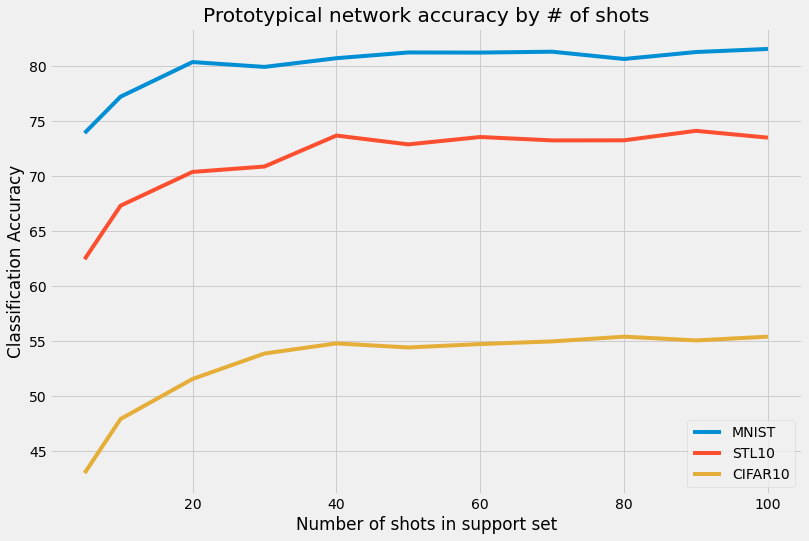

In [43]:
import matplotlib.pyplot as plt

shots = [5,10,20,30,40,50,60,70,80,90,100]



plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(shots, MNIST_results, label = "MNIST")
plt.plot(shots, STL10_results, label = "STL10")
plt.plot(shots, CIFAR10_results, label = "CIFAR10")

plt.xlabel("Number of shots in support set")
plt.ylabel("Classification Accuracy")
plt.title("Prototypical network accuracy by # of shots")
plt.legend()
plt.savefig("n_shot_fig.jpg")
